# Plot the output of count_events.py

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import oskar

### Import data

In [2]:
rid = '20160424_115511'
h5 = oskar.H5Data(rid)              # data
h5.load_log()
h5.pprint()
logDF = h5.log
vDF = h5.var_df()
uDF = h5.unique_df()
out_dire = h5.out_dire("Events")    # output
# count data
channels = ['CH_A0', 'CH_A1']
eventDF = h5.load_count(channels, include_vars=True)

20160424_115511
   Author:	 AA,BC
   Description:  Pulser delay scan, lineshapes at each delay
		 (pulser) DLY_GA: 1.05u, 1.4u, 10u
		 (lasers) DLY_EA: 635ns
		 IR: 755.63 - 761.81 (0.06)nm
		 T = 2.2kV
		 G = 200 V
		 Initial temp: 97.1deg 


In [3]:
uDF.head()

,DLY_EA,DLY_GA,IR,VOL_u101,VOL_u104
VID,,,,,
1,6.350000e-07,0.000001,755.63,200,2200
2,6.350000e-07,0.000001,755.69,200,2200
3,6.350000e-07,0.000001,755.75,200,2200
4,6.350000e-07,0.000001,755.81,200,2200
5,6.350000e-07,0.000001,755.87,200,2200


In [4]:
eventDF.head()

trigger         width       amp  squid  rep        DLY_EA  \
FTYPE EVENT                                                                   
CH_A0 0      7.860000e-07  7.260000e-07  0.088722      1    1  6.350000e-07   
      1      1.590000e-06  4.200000e-08  0.009707      1    1  6.350000e-07   
      2      3.984000e-06  6.000000e-08  0.017290      1    1  6.350000e-07   
      3      4.992000e-06  4.200000e-08  0.013464      1    1  6.350000e-07   
      4      5.466000e-06  4.200000e-08  0.009707      1    1  6.350000e-07   

               DLY_GA      IR  VOL_u101  VOL_u104  
FTYPE EVENT                                        
CH_A0 0      0.000001  756.77       200      2200  
      1      0.000001  756.77       200      2200  
      2      0.000001  756.77       200      2200  
      3      0.000001  756.77       200      2200  
      4      0.000001  756.77       200      2200

In [5]:
eventDF.describe()

,trigger,width,amp,squid,rep,DLY_EA,DLY_GA,IR,VOL_u101,VOL_u104
count,6.387770e+05,6.387770e+05,638777.000000,638777.000000,638777.000000,6.387770e+05,638777.000000,638777.000000,638777.0,638777.0
mean,2.011700e-06,1.756689e-07,0.029479,365.922060,50.535467,6.350000e-07,0.000004,758.716698,200.0,2200.0
std,1.494315e-06,2.169283e-07,0.032574,210.648949,28.866381,9.533363e-18,0.000004,1.808765,0.0,0.0
min,0.000000e+00,2.400000e-08,0.004070,1.000000,1.000000,6.350000e-07,0.000001,755.630000,200.0,2200.0
25%,8.520000e-07,4.200000e-08,0.008737,184.000000,26.000000,6.350000e-07,0.000001,757.130000,200.0,2200.0
50%,1.614000e-06,6.000000e-08,0.012613,366.000000,51.000000,6.350000e-07,0.000001,758.750000,200.0,2200.0
75%,2.202000e-06,1.740000e-07,0.026113,550.000000,76.000000,6.350000e-07,0.000010,760.310000,200.0,2200.0
max,9.966000e-06,1.098000e-06,0.089101,730.000000,103.000000,6.350000e-07,0.000010,761.810000,200.0,2200.0


## Estimate positron implanation time

In [6]:
# check the event spectra to ensure this makes sense
t0 = (eventDF[eventDF.amp > 0.07].trigger).mean()
print('t0 = %.2f us'%(t0*1e6))

t0 = 0.85 us


## Plot trigger time histogram

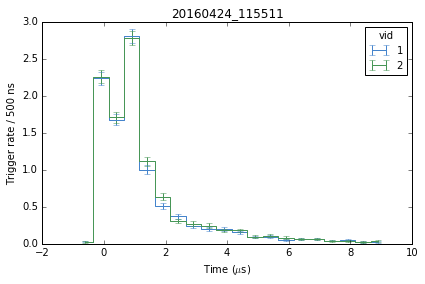

In [7]:
# histogram bins
bin_width = 0.5
bins=np.arange(0,10 + bin_width, bin_width)
x_vals = bins[:-1] + bin_width/2  # center of each bin

# data
VIDS = [1, 2]
#plot setup
fig, ax = plt.subplots(figsize=(6,4))
j = 0
for vid in VIDS:
    # select data
    data = eventDF[(eventDF[uDF.columns] == uDF.loc[vid]).all(1)]
    acq_on = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
    trigs = (data['trigger'].values)*1e6
    n_on = np.histogram(trigs, bins=bins)
    # y-axis, normalise data to acquisition time
    y_vals =  np.divide(n_on[0], acq_on)
    yerr  = np.sqrt(n_on[0])/ acq_on
    ax.errorbar(x_vals - t0*1e6, y_vals, yerr=yerr, drawstyle='steps-mid',
                label='%d'%vid, color=oskar.colors[j])
    ax.set_ylabel("Trigger rate / 500 ns")
    ax.axhline(0, color='k', alpha=0.5)
    j = j + 1

# format
ax.legend(loc=0, fontsize=10, title='vid')
ax.set_xlabel(r"Time ($\mu$s)");
ax.set_title(rid);

# save data
plt.tight_layout();
fileout = os.path.join(out_dire, 'hist_total.png')
#plt.savefig(fileout, dpi=150)
plt.show()

## Background subtract

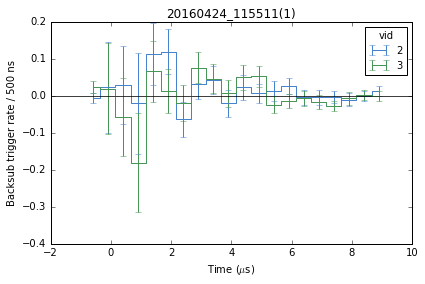

In [8]:
# histogram bins
bin_width = 0.5
bins=np.arange(0,10 + bin_width, bin_width)
x_vals = bins[:-1] + bin_width/2  # center of each bin

# background
vid_off = 1
background = eventDF[(eventDF[uDF.columns] == uDF.loc[vid_off]).all(1)]
acq_off = logDF.loc[np.unique(background.squid.values), 'ACQUIRE'].sum()
bktrigs = (background['trigger'].values)*1e6
n_off = np.histogram(bktrigs, bins=bins)

# data
VIDS = [2, 3]
#plot setup
fig, ax = plt.subplots(figsize=(6,4))
j = 0
for vid in VIDS:
    # select data
    data = eventDF[(eventDF[uDF.columns] == uDF.loc[vid]).all(1)]
    acq_on = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
    trigs = (data['trigger'].values)*1e6
    n_on = np.histogram(trigs, bins=bins)
    # y-axis, normalise data to acquisition time
    y_vals =  n_on[0] / float(acq_on) - n_off[0] / float(acq_off)
    # error
    yerr  = np.sqrt(n_on[0]/ float(acq_on**2.0) + n_off[0] / float(acq_off**2.0))
    ax.errorbar(x_vals - t0*1e6, y_vals, yerr=yerr, drawstyle='steps-mid',
                label='%d'%vid, color=oskar.colors[j])
    ax.set_ylabel("Backsub trigger rate / 500 ns")
    ax.axhline(0, color='k', alpha=0.5)
    j = j + 1

# format
ax.legend(loc=0, fontsize=10, title='vid')
ax.set_xlabel(r"Time ($\mu$s)");
ax.set_title(rid + "(" + str(vid_off)+ ")");

# save data
plt.tight_layout();
fileout = os.path.join(out_dire, 'hist_bksub.png')
#plt.savefig(fileout, dpi=150)
plt.show()